In [45]:
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
import weaviate
import weaviate.classes as wvc
from weaviate.classes.config import Property, DataType
import base64
from PIL import Image
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, normalize
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


In [46]:
client = weaviate.connect_to_local(
    host="localhost", 
    port=8080,
    skip_init_checks=True  # Skip the problematic gRPC health check
)

if client.is_ready():
    print("✅ Connected to Weaviate successfully")
    # Test the connection manually
    try:
        meta = client.get_meta()
        print(f"Weaviate version: {meta['version']}")
        print(f"Available modules: {list(meta['modules'].keys())}")
    except Exception as e:
        print(f"⚠️  Connected but with limitations: {e}")
else:
    print("❌ Cannot connect to Weaviate")

✅ Connected to Weaviate successfully
Weaviate version: 1.25.0
Available modules: ['multi2vec-clip']


In [48]:
collection_name = "IndividualBird"

# Delete if exists
if client.collections.exists(collection_name):
    print(f"Deleting existing {collection_name} collection...")
    client.collections.delete(collection_name)

# Create collection with just image vectorization
print(f"Creating {collection_name} collection...")

collection = client.collections.create(
    name=collection_name,
    vectorizer_config=wvc.config.Configure.Vectorizer.multi2vec_clip(
        image_fields=["image"]  # Only vectorize the image
    ),
    properties=[
        Property(name="image", data_type=DataType.BLOB),
        Property(name="filename", data_type=DataType.TEXT),
        Property(name="weight_grams", data_type=DataType.NUMBER),
        Property(name="visit_hour", data_type=DataType.INT),
        Property(name="visit_date", data_type=DataType.TEXT),
        Property(name="is_daylight", data_type=DataType.TEXT),
    ]
)

print("✅ Collection created successfully")

Creating IndividualBird collection...
✅ Collection created successfully


In [49]:
def encode_image_to_base64(image_path):
    """Convert image to base64 for Weaviate"""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

def is_daylight_hour(hour):
    """Determine if hour is daylight (6 AM to 7 PM) - returns string"""
    return "true" if 6 <= hour <= 19 else "false"

def parse_bird_filename(filename):
    """
    Parse bird filename to extract species, date, time, and weight
    Example: robin_20250801_193326_21.1g.jpg
    Format: species_YYYYMMDD_HHMMSS_weight.jpg
    Returns: dict with parsed data
    """
    parts = filename.stem.split('_')
    
    if len(parts) >= 4:
        species = parts[0]           # robin
        date_str = parts[1]          # 20250801
        time_str = parts[2]          # 193326
        weight_part = parts[3]       # 21.1g
        
        # Remove 'g' from weight
        weight_str = weight_part.replace('g', '')
        
        # Parse date and time
        try:
            date_obj = datetime.strptime(date_str, '%Y%m%d')
            hour = int(time_str[:2])
            minute = int(time_str[2:4])
            second = int(time_str[4:6])
            
            datetime_obj = datetime.combine(
                date_obj.date(), 
                datetime.min.time().replace(hour=hour, minute=minute, second=second)
            )
            
            weight = float(weight_str)
            
            return {
                'species': species,
                'date': date_obj.date(),
                'datetime': datetime_obj,
                'hour': hour,
                'minute': minute,
                'weight_grams': weight,
                'filename': filename.name,
                'filepath': str(filename)
            }
        except Exception as e:
            print(f"Error parsing {filename.name}: {e}")
            print(f"  Parts: {parts}")
            print(f"  Weight part: '{weight_part}' -> '{weight_str}'")
            return None
    else:
        print(f"Unexpected filename format: {filename.name} (expected 4+ parts, got {len(parts)})")
        return None

print("✅ Helper functions defined")

✅ Helper functions defined


In [50]:
images_dir = Path("../identified_images")
all_files = list(images_dir.glob("*.jpg"))

print(f"Found {len(all_files)} images")
print("\nFirst few files:")
for i, file in enumerate(all_files[:5]):
    print(f"  {i+1}. {file.name}")

# Parse and analyze the data
bird_data = []
daylight_count = 0
nighttime_count = 0

for file in all_files:
    parsed = parse_bird_filename(file)
    if parsed:
        is_daylight = is_daylight_hour(parsed['hour'])
        
        bird_data.append({
            'filename': file.name,
            'weight': parsed['weight_grams'],
            'hour': parsed['hour'],
            'is_daylight': is_daylight,
            'date': parsed['date']
        })
        
        if is_daylight == "true":
            daylight_count += 1
        else:
            nighttime_count += 1

df = pd.DataFrame(bird_data)
print(f"\nSummary:")
print(f"  Daylight photos: {daylight_count}")
print(f"  Nighttime photos: {nighttime_count}")
if len(df) > 0:
    print(f"  Weight range: {df['weight'].min():.1f}g - {df['weight'].max():.1f}g")

# Example filename parsing
print("\nExample filename parsing:")
for file in all_files[:3]:
    parsed = parse_bird_filename(file)
    if parsed:
        print(f"  {file.name}")
        print(f"    -> Species: {parsed['species']}, Date: {parsed['date']}, Time: {parsed['hour']:02d}:{parsed['minute']:02d}, Weight: {parsed['weight_grams']}g")


Found 21 images

First few files:
  1. robin_20250729_052852_21.5g.jpg
  2. robin_20250731_221432_21.1g.jpg
  3. robin_20250801_194819_25.4g.jpg
  4. robin_20250801_105023_19.5g.jpg
  5. robin_20250801_172432_13.9g.jpg

Summary:
  Daylight photos: 13
  Nighttime photos: 8
  Weight range: 13.9g - 26.6g

Example filename parsing:
  robin_20250729_052852_21.5g.jpg
    -> Species: robin, Date: 2025-07-29, Time: 05:28, Weight: 21.5g
  robin_20250731_221432_21.1g.jpg
    -> Species: robin, Date: 2025-07-31, Time: 22:14, Weight: 21.1g
  robin_20250801_194819_25.4g.jpg
    -> Species: robin, Date: 2025-08-01, Time: 19:48, Weight: 25.4g


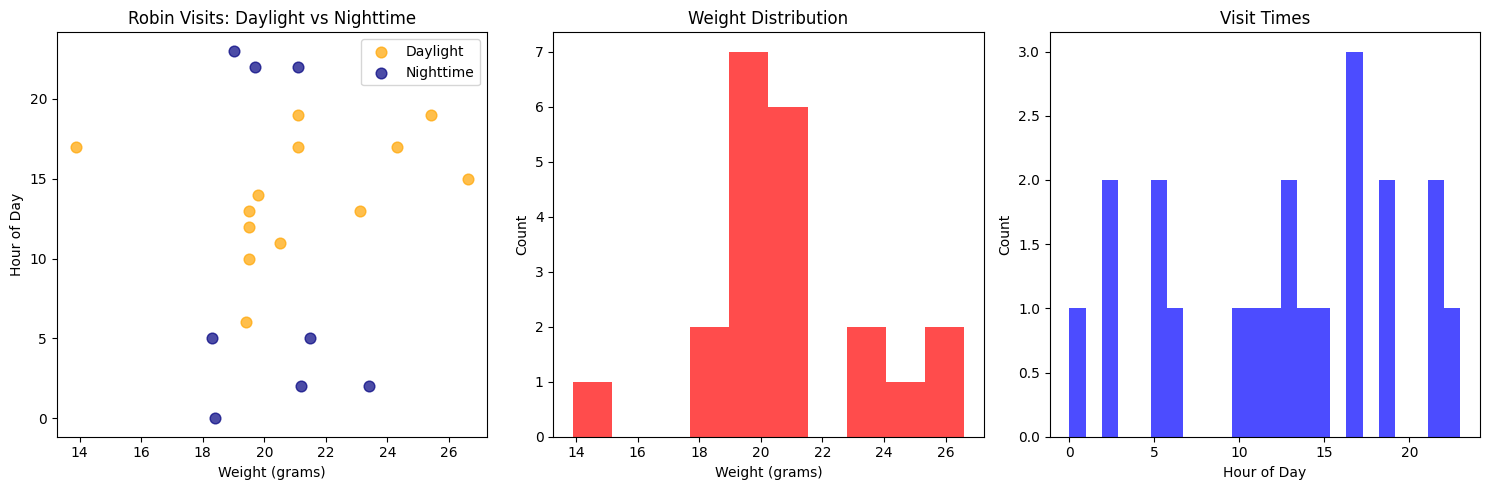

📊 Data visualization complete


In [ ]:
if len(df) > 0:
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    daylight_mask = df['is_daylight'] == "true"
    plt.scatter(df[daylight_mask]['weight'], df[daylight_mask]['hour'], 
               alpha=0.7, color='orange', label='Daylight', s=60)
    plt.scatter(df[~daylight_mask]['weight'], df[~daylight_mask]['hour'], 
               alpha=0.7, color='navy', label='Nighttime', s=60)
    plt.xlabel('Weight (grams)')
    plt.ylabel('Hour of Day')
    plt.title('Visits: Daylight vs Nighttime')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.hist(df['weight'], bins=10, alpha=0.7, color='red')
    plt.xlabel('Weight (grams)')
    plt.ylabel('Count')
    plt.title('Weight Distribution')

    plt.subplot(1, 3, 3)
    plt.hist(df['hour'], bins=24, alpha=0.7, color='blue')
    plt.xlabel('Hour of Day')
    plt.ylabel('Count')
    plt.title('Visit Times')

    plt.tight_layout()
    plt.show()

    print("📊 Data visualization complete")
else:
    print("❌ No data to visualize")

In [ ]:
print("Loading images into Weaviate...")
print("This may take a few minutes to generate image embeddings...")

added_count = 0

for file in all_files:
    try:
        # Parse filename
        parts = file.stem.split('_')
        if len(parts) >= 4:
            date_str = parts[1]
            time_str = parts[2] 
            weight_str = parts[3].replace('g', '')
            
            hour = int(time_str[:2])
            weight = float(weight_str)
            is_daylight = is_daylight_hour(hour)
            
            # Encode image
            image_b64 = encode_image_to_base64(file)
            
            # Insert into Weaviate (no text descriptions needed)
            uuid = collection.data.insert({
                "image": image_b64,
                "filename": file.name,
                "weight_grams": weight,
                "visit_hour": hour,
                "visit_date": date_str,
                "is_daylight": is_daylight
            })
            
            added_count += 1
            print(f"✅ {added_count}/{len(all_files)}: {file.name}")
            
    except Exception as e:
        print(f"❌ Error processing {file.name}: {e}")

print(f"\n🎉 Successfully loaded {added_count} images with CLIP embeddings!")

Loading robin images into Weaviate...
This may take a few minutes to generate image embeddings...
✅ 1/17: robin_20250729_052852_21.5g.jpg
✅ 2/17: robin_20250731_221432_21.1g.jpg
✅ 3/17: robin_20250801_194819_25.4g.jpg
✅ 4/17: robin_20250801_105023_19.5g.jpg
✅ 5/17: robin_20250801_172432_13.9g.jpg
✅ 6/17: robin_20250801_173847_21.1g.jpg
✅ 7/17: robin_20250801_110124_20.5g.jpg
✅ 8/17: robin_20250801_120750_19.5g.jpg
✅ 9/17: robin_20250729_004950_18.4g.jpg
✅ 10/17: robin_20250801_193326_21.1g.jpg
✅ 11/17: robin_20250801_022924_23.4g.jpg
✅ 12/17: robin_20250801_131204_23.1g.jpg
✅ 13/17: robin_20250730_220830_19.7g.jpg
✅ 14/17: robin_20250801_174149_24.3g.jpg
✅ 15/17: robin_20250730_234740_19.0g.jpg
✅ 16/17: robin_20250731_020239_21.2g.jpg
✅ 17/17: robin_20250801_154114_26.6g.jpg

🎉 Successfully loaded 17 robin images with CLIP embeddings!


In [ ]:
print("Extracting CLIP embeddings from Weaviate...")

# Get all robin data with embeddings
response = collection.query.fetch_objects(
    return_properties=["filename", "weight_grams", "visit_hour", "is_daylight"],
    include_vector=True
)

print(f"Retrieved {len(response.objects)} objects with embeddings")

# Extract image embeddings and metadata
image_embeddings = []
metadata = []

for obj in response.objects:
    image_embeddings.append(obj.vector["default"])  # CLIP image embedding
    filename = obj.properties["filename"]
    species = filename.split('_')[0]
    metadata.append({
        "filename": obj.properties["filename"],
        "species": species,
        "weight": obj.properties["weight_grams"],
        "hour": obj.properties["visit_hour"],
        "is_daylight": obj.properties["is_daylight"]
    })

image_embeddings = np.array(image_embeddings)
metadata_df = pd.DataFrame(metadata)

print(f"✅ Extracted {len(image_embeddings)} image embeddings")
print(f"   Image embedding dimension: {image_embeddings.shape[1]}")
print(f"   Daylight photos: {(metadata_df['is_daylight'] == 'true').sum()}")
print(f"   Nighttime photos: {(metadata_df['is_daylight'] == 'false').sum()}")


Extracting CLIP embeddings from Weaviate...
Retrieved 17 objects with embeddings
✅ Extracted 17 image embeddings
   Image embedding dimension: 512
   Daylight photos: 10
   Nighttime photos: 7


In [39]:
def create_numerical_features(metadata_df):
    """Create normalized numerical features for weight and time"""
    
    features = []
    
    for _, row in metadata_df.iterrows():
        # Normalize weight (subtract mean, divide by std)
        weight_norm = (row['weight'] - metadata_df['weight'].mean()) / metadata_df['weight'].std()
        
        # Encode time cyclically (so 23:00 and 01:00 are close)
        hour_sin = np.sin(2 * np.pi * row['hour'] / 24)
        hour_cos = np.cos(2 * np.pi * row['hour'] / 24)
        
        numerical_features = [weight_norm, hour_sin, hour_cos]
        features.append(numerical_features)
    
    return np.array(features)

print("Creating hybrid vectors: Image embeddings + numerical features...")

# Create numerical features
numerical_features = create_numerical_features(metadata_df)
print(f"✅ Created numerical features with shape: {numerical_features.shape}")

# Scale numerical features to match image embedding magnitude
scaler = StandardScaler()
numerical_scaled = scaler.fit_transform(numerical_features)

# Weight the numerical features (experiment with this)
numerical_weight = 0.3  # 30% weight to numerical, 70% to image
numerical_scaled = numerical_scaled * numerical_weight

# Concatenate image and numerical features
hybrid_embeddings = np.concatenate([image_embeddings, numerical_scaled], axis=1)

print(f"✅ Created hybrid embeddings with shape: {hybrid_embeddings.shape}")
print(f"   Image dimensions: {image_embeddings.shape[1]}")
print(f"   Numerical dimensions: {numerical_scaled.shape[1]}")
print(f"   Total dimensions: {hybrid_embeddings.shape[1]}")

Creating hybrid vectors: Image embeddings + numerical features...
✅ Created numerical features with shape: (17, 3)
✅ Created hybrid embeddings with shape: (17, 515)
   Image dimensions: 512
   Numerical dimensions: 3
   Total dimensions: 515


In [40]:
daylight_mask = metadata_df['is_daylight'] == "true"
hybrid_daylight = hybrid_embeddings[daylight_mask]
metadata_daylight = metadata_df[daylight_mask].copy()

print(f"Focusing on {len(hybrid_daylight)} daylight photos for clustering")

if len(hybrid_daylight) < 2:
    print("❌ Not enough daylight photos for clustering!")
else:
    # Normalize the hybrid embeddings
    hybrid_norm = normalize(hybrid_daylight, norm='l2')
    
    # Try different clustering parameters
    eps_values = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
    results = []
    
    print("Testing clustering parameters on hybrid embeddings...")
    
    for eps in eps_values:
        dbscan = DBSCAN(eps=eps, min_samples=2, metric='cosine')
        clusters = dbscan.fit_predict(hybrid_norm)
        
        n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
        n_noise = sum(clusters == -1)
        
        results.append({
            'eps': eps,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'clusters': clusters
        })
        
        print(f"eps={eps}: {n_clusters} clusters, {n_noise} noise points")
    
    # Choose best eps (prefer 2-4 clusters with moderate noise)
    best_result = None
    for result in results:
        if 2 <= result['n_clusters'] <= 4 and result['n_noise'] < len(hybrid_daylight) * 0.7:
            best_result = result
            break
    
    if best_result is None:
        best_result = results[len(results)//2]
    
    print(f"\n🎯 Using eps={best_result['eps']} with {best_result['n_clusters']} clusters")

Focusing on 10 daylight photos for clustering
Testing clustering parameters on hybrid embeddings...
eps=0.1: 1 clusters, 1 noise points
eps=0.15: 1 clusters, 0 noise points
eps=0.2: 1 clusters, 0 noise points
eps=0.25: 1 clusters, 0 noise points
eps=0.3: 1 clusters, 0 noise points
eps=0.35: 1 clusters, 0 noise points
eps=0.4: 1 clusters, 0 noise points

🎯 Using eps=0.25 with 1 clusters


In [41]:
clusters = best_result['clusters']
metadata_daylight['cluster'] = clusters

unique_clusters = np.unique(clusters)
n_clusters = len([c for c in unique_clusters if c != -1])
n_noise = sum(clusters == -1)

print(f"=== Hybrid Vector Clustering Results ===")
print(f"Found {n_clusters} potential individual robins")
print(f"Noise points (unclustered): {n_noise}")

# Analyze each cluster
for cluster_id in sorted(unique_clusters):
    cluster_data = metadata_daylight[metadata_daylight['cluster'] == cluster_id]
    
    if cluster_id == -1:
        print(f"\n🔍 Noise Points ({len(cluster_data)} photos):")
    else:
        print(f"\n🐦 Individual Robin {cluster_id} ({len(cluster_data)} photos):")
    
    print(f"   Weight: {cluster_data['weight'].min():.1f}-{cluster_data['weight'].max():.1f}g "
          f"(avg: {cluster_data['weight'].mean():.1f}±{cluster_data['weight'].std():.1f}g)")
    print(f"   Hours: {cluster_data['hour'].min()}-{cluster_data['hour'].max()}")
    print(f"   Files: {', '.join(cluster_data['filename'].tolist()[:3])}")
    if len(cluster_data) > 3:
        print(f"           ...and {len(cluster_data)-3} more")


=== Hybrid Vector Clustering Results ===
Found 1 potential individual robins
Noise points (unclustered): 0

🐦 Individual Robin 0 (10 photos):
   Weight: 13.9-26.6g (avg: 21.5±3.6g)
   Hours: 10-19
   Files: robin_20250801_105023_19.5g.jpg, robin_20250801_173847_21.1g.jpg, robin_20250801_172432_13.9g.jpg
           ...and 7 more


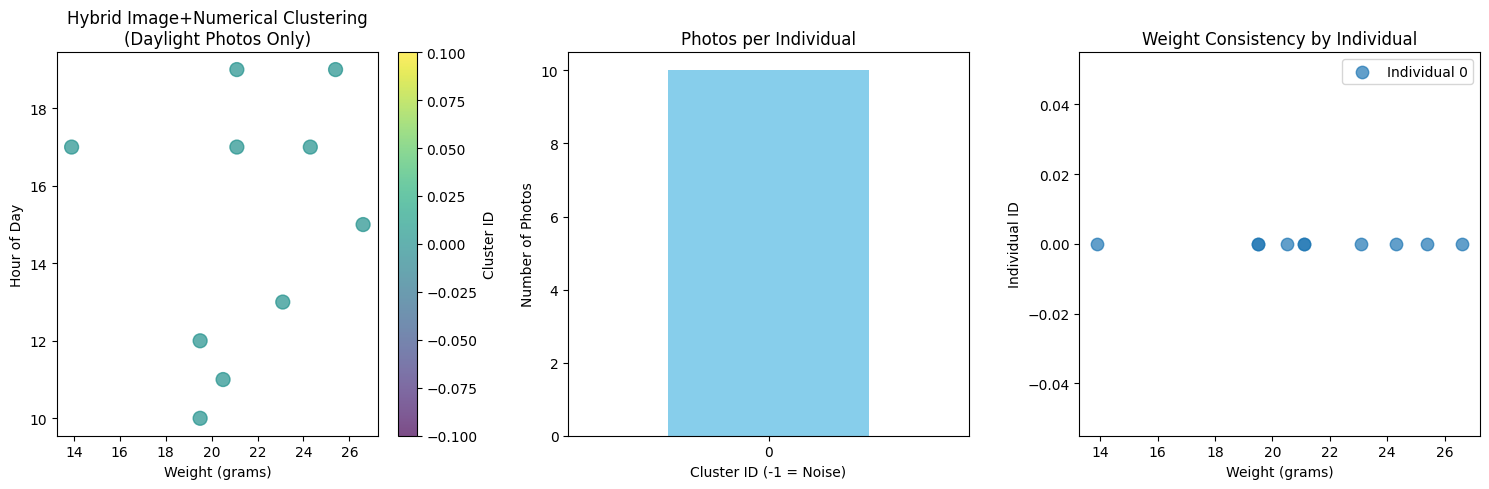

In [42]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
scatter = plt.scatter(metadata_daylight['weight'], metadata_daylight['hour'], 
                     c=metadata_daylight['cluster'], cmap='viridis', alpha=0.7, s=100)
plt.xlabel('Weight (grams)')
plt.ylabel('Hour of Day')
plt.title('Hybrid Image+Numerical Clustering\n(Daylight Photos Only)')
plt.colorbar(scatter, label='Cluster ID')

plt.subplot(1, 3, 2)
cluster_counts = metadata_daylight['cluster'].value_counts().sort_index()
cluster_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Cluster ID (-1 = Noise)')
plt.ylabel('Number of Photos')
plt.title('Photos per Individual')
plt.xticks(rotation=0)

plt.subplot(1, 3, 3)
for cluster_id in unique_clusters:
    if cluster_id != -1:
        cluster_data = metadata_daylight[metadata_daylight['cluster'] == cluster_id]
        plt.scatter(cluster_data['weight'], [cluster_id] * len(cluster_data), 
                   alpha=0.7, s=80, label=f'Individual {cluster_id}')

plt.xlabel('Weight (grams)')
plt.ylabel('Individual ID')
plt.title('Weight Consistency by Individual')
if n_clusters > 0:
    plt.legend()

plt.tight_layout()
plt.show()


=== Individual Robin 0 ===
Weight consistency: 3.6g standard deviation


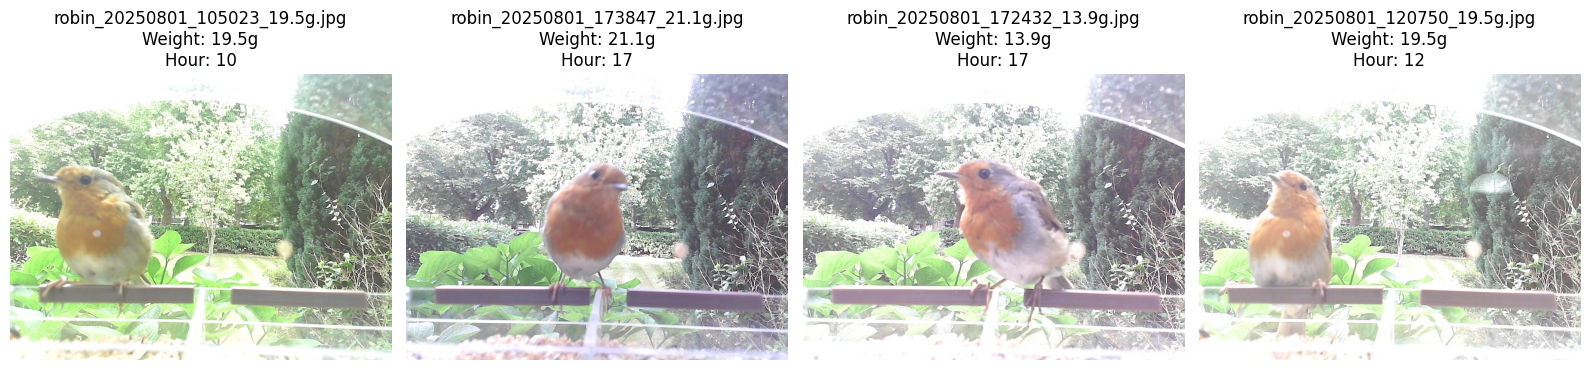


🎉 Individual robin identification complete!


In [43]:
for cluster_id in sorted(unique_clusters):
    if cluster_id == -1:
        continue  # Skip noise for now
        
    cluster_data = metadata_daylight[metadata_daylight['cluster'] == cluster_id]
    print(f"\n=== Individual Robin {cluster_id} ===")
    print(f"Weight consistency: {cluster_data['weight'].std():.1f}g standard deviation")
    
    # Show up to 4 images from this individual
    n_images = min(len(cluster_data), 4)
    fig, axes = plt.subplots(1, n_images, figsize=(4*n_images, 4))
    
    if n_images == 1:
        axes = [axes]
    
    for i, (idx, row) in enumerate(cluster_data.head(n_images).iterrows()):
        img_path = images_dir / row['filename']
        if img_path.exists():
            img = Image.open(img_path)
            axes[i].imshow(img)
            axes[i].set_title(f"{row['filename']}\nWeight: {row['weight']:.1f}g\nHour: {row['hour']}")
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

print("\n🎉 Individual robin identification complete!")

In [44]:
print("=== Comparing Pure Image vs Hybrid Clustering ===")

# Pure image clustering for comparison
image_daylight = image_embeddings[daylight_mask]
image_norm = normalize(image_daylight, norm='l2')

# Use same eps as hybrid for fair comparison
dbscan_image = DBSCAN(eps=best_result['eps'], min_samples=2, metric='cosine')
image_clusters = dbscan_image.fit_predict(image_norm)

image_n_clusters = len(set(image_clusters)) - (1 if -1 in image_clusters else 0)
hybrid_n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)

print(f"Pure image clustering: {image_n_clusters} clusters")
print(f"Hybrid clustering: {hybrid_n_clusters} clusters")

# Show weight consistency comparison
print(f"\nWeight consistency comparison:")
if image_n_clusters > 0:
    print("Pure image clusters:")
    for cluster_id in set(image_clusters):
        if cluster_id != -1:
            cluster_mask = image_clusters == cluster_id
            cluster_weights = metadata_daylight.iloc[np.where(cluster_mask)[0]]['weight']
            print(f"  Cluster {cluster_id}: {cluster_weights.std():.1f}g std dev")

if hybrid_n_clusters > 0:
    print("Hybrid clusters:")
    for cluster_id in set(clusters):
        if cluster_id != -1:
            cluster_mask = clusters == cluster_id
            cluster_weights = metadata_daylight.iloc[np.where(cluster_mask)[0]]['weight']
            print(f"  Cluster {cluster_id}: {cluster_weights.std():.1f}g std dev")

=== Comparing Pure Image vs Hybrid Clustering ===
Pure image clustering: 1 clusters
Hybrid clustering: 1 clusters

Weight consistency comparison:
Pure image clusters:
  Cluster 0: 3.6g std dev
Hybrid clusters:
  Cluster 0: 3.6g std dev
